In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')

In [2]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
import xgboost as xgb
from time import time

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline

# 载入客户数据集
try:
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    df_store = pd.read_csv("store.csv")
except:
    print "Dataset could not be loaded. Is the dataset missing?"

/home/bairui/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [82]:
print("Consider only open stores for training. Closed stores wont count into the score.")
df_train = df_train[df_train["Open"] != 0]
print("Use only Sales bigger then zero")
df_train = df_train[df_train["Sales"] > 0]

Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero


In [4]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
#特征值预处理
#def build_features

In [7]:
# 显示train特征
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# 引入datetime,并且对date特征进行分割
import datetime
sales_raw = df_train["Sales"]
df_train['Year']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)
df_train['Month']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
df_train['Day']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)

#将Date特征移除
features_raw = df_train.drop("Date",axis = 1)

In [9]:
#预览feature_raw
features_raw.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,5,5263,555,1,1,0,1,2015,7,31
1,2,5,6064,625,1,1,0,1,2015,7,31
2,3,5,8314,821,1,1,0,1,2015,7,31
3,4,5,13995,1498,1,1,0,1,2015,7,31
4,5,5,4822,559,1,1,0,1,2015,7,31


In [10]:
features_raw.shape

(1017209, 11)

In [11]:
train_store=pd.merge(features_raw, df_store, how = 'left', on = 'Store')
train_store['SalePerCustomer'] = features_raw['Sales']/features_raw['Customers']

In [12]:
# 显示store特征
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,9.482883
1,2,5,6064,625,1,1,0,1,2015,7,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,8314,821,1,1,0,1,2015,7,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,13995,1498,1,1,0,1,2015,7,...,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,9.342457
4,5,5,4822,559,1,1,0,1,2015,7,...,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,8.626118


In [13]:
# 对store数据集查找缺省值
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
SalePerCustomer              172869
dtype: int64

In [14]:
train_store[pd.isnull(train_store.SalePerCustomer)].shape

(172869, 21)

In [15]:
# 填充缺省值为0
train_store['SalePerCustomer'].fillna(0, inplace = True)

In [16]:
# 查看CompetitionDistance特征中的缺省值
train_store[pd.isnull(train_store.CompetitionDistance)].shape

(2642, 21)

In [17]:
# 填充缺省值为median平均值
train_store['CompetitionDistance'].fillna(train_store['CompetitionDistance'].median(), inplace = True)

In [18]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,9.482883
1,2,5,6064,625,1,1,0,1,2015,7,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,8314,821,1,1,0,1,2015,7,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,13995,1498,1,1,0,1,2015,7,...,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,9.342457
4,5,5,4822,559,1,1,0,1,2015,7,...,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,8.626118


In [19]:
train_store.columns

Index([u'Store', u'DayOfWeek', u'Sales', u'Customers', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'Year', u'Month', u'Day',
       u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval',
       u'SalePerCustomer'],
      dtype='object')

In [20]:
# 增加Store的店销售
store_etc1=train_store.groupby('Store')['Sales'].describe().reset_index()

store_etc1=store_etc1[['Store','mean']]

store_etc1.rename(columns={'mean':'AvgPerStore'}, inplace = True)

store_etc1.head()

,Store,AvgPerStore
0,1,3945.704883
1,2,4122.991507
2,3,5741.253715
3,4,8021.769639
4,5,3867.110403


In [21]:
# 增加DayOfWeek的店销售
store_etc2=train_store.groupby('DayOfWeek')['Sales'].describe().reset_index()

store_etc2=store_etc2[['DayOfWeek','mean']]

store_etc2.rename(columns={'mean':'AvgPerDayOfWeek'}, inplace = True)

display(store_etc2)

,DayOfWeek,AvgPerDayOfWeek
0,1,7809.044510
1,2,7005.244467
2,3,6555.884138
3,4,6247.575913
4,5,6723.274305
5,6,5847.562599
6,7,204.183189


In [22]:
# 增加open的店销售
store_etc3=train_store.groupby('Open')['Sales'].describe().reset_index()

store_etc3=store_etc3[['Open','mean']]

store_etc3.rename(columns={'mean':'AvgPerOpen'}, inplace = True)

display(store_etc3)

,Open,AvgPerOpen
0,0,0.000000
1,1,6955.514291


In [23]:
# 增加Promo的店销售
store_etc4=train_store.groupby('Promo')['Sales'].describe().reset_index()

store_etc4=store_etc4[['Promo','mean']]

store_etc4.rename(columns={'mean':'AvgPerPromo'}, inplace = True)

display(store_etc4)

,Promo,AvgPerPromo
0,0,4406.050805
1,1,7991.152046


In [24]:
# 增加SchoolHoliday的店销售
store_etc5=train_store.groupby('SchoolHoliday')['Sales'].describe().reset_index()

store_etc5=store_etc5[['SchoolHoliday','mean']]

store_etc5.rename(columns={'mean':'AvgPerSchoolHoliday'}, inplace = True)

display(store_etc5)

,SchoolHoliday,AvgPerSchoolHoliday
0,0,5620.979034
1,1,6476.522207


In [25]:
# 增加Year的店销售
store_etc6=train_store.groupby('Year')['Sales'].describe().reset_index()

store_etc6=store_etc6[['Year','mean']]

store_etc6.rename(columns={'mean':'AvgPerYear'}, inplace = True)

display(store_etc6)

,Year,AvgPerYear
0,2013,5658.533675
1,2014,5833.290704
2,2015,5878.245380


In [26]:
# 增加Month的销售
store_etc7=train_store.groupby('Month')['Sales'].describe().reset_index()

store_etc7=store_etc7[['Month','mean']]

store_etc7.rename(columns={'mean':'AvgPerMonth'}, inplace = True)

display(store_etc7)

,Month,AvgPerMonth
0,1,5465.395529
1,2,5645.253150
2,3,5784.578871
3,4,5738.866916
4,5,5489.639973
5,6,5760.964375
6,7,6064.915711
7,8,5693.016554
8,9,5570.246033
9,10,5537.037419


In [27]:
# 增加Day的销售
store_etc8=train_store.groupby('Day')['Sales'].describe().reset_index()

store_etc8=store_etc8[['Day','mean']]

store_etc8.rename(columns={'mean':'AvgPerDay'}, inplace = True)

display(store_etc8)

,Day,AvgPerDay
0,1,4658.450603
1,2,6973.664895
2,3,5811.044109
3,4,6818.008362
4,5,6357.150246
5,6,5886.054621
6,7,6014.050679
7,8,5665.783784
8,9,5253.768165
9,10,5406.580947


In [28]:
# 转化Stateholiday里的0
train_store['StateHoliday']=train_store['StateHoliday'].replace({'0':0})

In [29]:
# 增加StateHoliday的店销售
store_etc9=train_store.groupby('StateHoliday')['Sales'].describe().reset_index()

store_etc9=store_etc9[['StateHoliday','mean']]

store_etc9.rename(columns={'mean':'AvgPerStateHoliday'}, inplace = True)

display(store_etc9)

,StateHoliday,AvgPerStateHoliday
0,0,5947.483893
1,a,290.735686
2,b,214.311510
3,c,168.733171


In [30]:
# 各类型门店有几个
from collections import Counter
c = Counter(df_store['StoreType'])
print c

Counter({'a': 602, 'd': 348, 'c': 148, 'b': 17})


In [31]:
# 增加StoreType的店销售
store_etc10=train_store.groupby('StoreType')['Sales'].describe().reset_index()

store_etc10=store_etc10[['StoreType','mean']]

store_etc10.rename(columns={'mean':'AvgPerStoreType'}, inplace = True)

display(store_etc10)

,StoreType,AvgPerStoreType
0,a,5738.179710
1,b,10058.837334
2,c,5723.629246
3,d,5641.819243


In [32]:
# 增加Assortment的销售
store_etc11=train_store.groupby('Assortment')['Sales'].describe().reset_index()

store_etc11=store_etc11[['Assortment','mean']]

store_etc11.rename(columns={'mean':'AvgPerAssortment'}, inplace = True)

display(store_etc11)

,Assortment,AvgPerAssortment
0,a,5481.026096
1,b,8553.931999
2,c,6058.676567


In [33]:
# 增加CompetitionOpenSinceMonth的销售
store_etc12=train_store.groupby('CompetitionOpenSinceMonth')['Sales'].describe().reset_index()

store_etc12=store_etc12[['CompetitionOpenSinceMonth','mean']]

store_etc12.rename(columns={'mean':'AvgPerCompetitionOpenSinceMonth'}, inplace = True)

display(store_etc12)

,CompetitionOpenSinceMonth,AvgPerCompetitionOpenSinceMonth
0,1.0,6172.995021
1,2.0,5429.783060
2,3.0,6018.509804
3,4.0,5721.389568
4,5.0,6253.914209
5,6.0,6355.309018
6,7.0,5605.731231
7,8.0,6242.269193
8,9.0,5674.837021
9,10.0,5672.669411


In [34]:
# 增加Promo2的销售
store_etc13=train_store.groupby('Promo2')['Sales'].describe().reset_index()

store_etc13=store_etc13[['Promo2','mean']]

store_etc13.rename(columns={'mean':'AvgPerPromo2'}, inplace = True)

display(store_etc13)

,Promo2,AvgPerPromo2
0,0,6124.710161
1,1,5423.718218


In [35]:
# 增加PromoInterval的店销售
store_etc14=train_store.groupby('PromoInterval')['Sales'].describe().reset_index()

store_etc14=store_etc14[['PromoInterval','mean']]

store_etc14.rename(columns={'mean':'AvgPerPromoInterval'}, inplace = True)

display(store_etc14)

,PromoInterval,AvgPerPromoInterval
0,"Feb,May,Aug,Nov",5311.048585
1,"Jan,Apr,Jul,Oct",5562.364063
2,"Mar,Jun,Sept,Dec",5143.829243


In [36]:
# 增加Store的人均销售
store_etc15=train_store.groupby('Store')['SalePerCustomer'].describe().reset_index()

store_etc15=store_etc15[['Store','mean']]

store_etc15.rename(columns={'mean':'AvgPerCustomerPerStore'}, inplace = True)

store_etc15.head()

,Store,AvgPerCustomerPerStore
0,1,6.958559
1,2,6.998110
2,3,7.539925
3,4,6.033827
4,5,7.121176


In [37]:
# 增加DayOfWeek的人均销售
store_etc16=train_store.groupby('DayOfWeek')['SalePerCustomer'].describe().reset_index()

store_etc16=store_etc16[['DayOfWeek','mean']]

store_etc16.rename(columns={'mean':'AvgPerCustomerPerDayOfWeek'}, inplace = True)

display(store_etc16)

,DayOfWeek,AvgPerCustomerPerDayOfWeek
0,1,9.406471
1,2,9.481922
2,3,9.252783
3,4,8.638349
4,5,8.971573
5,6,9.216725
6,7,0.160346


In [38]:
# 增加Open的人均销售
store_etc17=train_store.groupby('Open')['SalePerCustomer'].describe().reset_index()

store_etc17=store_etc17[['Open','mean']]

store_etc17.rename(columns={'mean':'AvgPerCustomerPerOpen'}, inplace = True)

display(store_etc17)

,Open,AvgPerCustomerPerOpen
0,0,0.000000
1,1,9.493034


In [39]:
# 增加Promo的人均销售
store_etc18=train_store.groupby('Promo')['SalePerCustomer'].describe().reset_index()

store_etc18=store_etc18[['Promo','mean']]

store_etc18.rename(columns={'mean':'AvgPerCustomerPerPromo'}, inplace = True)

display(store_etc18)

,Promo,AvgPerCustomerPerPromo
0,0,6.643544
1,1,9.885065


In [40]:
# 增加SchoolHoliday的人均销售
store_etc19=train_store.groupby('SchoolHoliday')['SalePerCustomer'].describe().reset_index()

store_etc19=store_etc19[['SchoolHoliday','mean']]

store_etc19.rename(columns={'mean':'AvgPerCustomerPerSchoolHoliday'}, inplace = True)

display(store_etc19)

,SchoolHoliday,AvgPerCustomerPerSchoolHoliday
0,0,7.725410
1,1,8.592045


In [41]:
# 增加Year的人均销售
store_etc20=train_store.groupby('Year')['SalePerCustomer'].describe().reset_index()

store_etc20=store_etc20[['Year','mean']]

store_etc20.rename(columns={'mean':'AvgPerCustomerPerYear'}, inplace = True)

display(store_etc20)

,Year,AvgPerCustomerPerYear
0,2013,7.777135
1,2014,7.831030
2,2015,8.135548


In [42]:
# 增加month的人均销售
store_etc21=train_store.groupby('Month')['SalePerCustomer'].describe().reset_index()

store_etc21=store_etc21[['Month','mean']]

store_etc21.rename(columns={'mean':'AvgPerCustomerPerMonth'}, inplace = True)

display(store_etc21)

,Month,AvgPerCustomerPerMonth
0,1,7.866232
1,2,8.042086
2,3,7.923162
3,4,7.712215
4,5,7.367752
5,6,7.898683
6,7,8.407362
7,8,7.920826
8,9,7.767740
9,10,7.694336


In [43]:
# 增加Day的人均销售
store_etc22=train_store.groupby('Day')['SalePerCustomer'].describe().reset_index()

store_etc22=store_etc22[['Day','mean']]

store_etc22.rename(columns={'mean':'AvgPerCustomerPerDay'}, inplace = True)

display(store_etc22)

,Day,AvgPerCustomerPerDay
0,1,5.748761
1,2,8.617989
2,3,7.416632
3,4,8.678992
4,5,8.263842
5,6,7.914044
6,7,8.097401
7,8,7.840295
8,9,7.527813
9,10,7.708582


In [44]:
# 增加StateHoliday的人均销售
store_etc23=train_store.groupby('StateHoliday')['SalePerCustomer'].describe().reset_index()

store_etc23=store_etc23[['StateHoliday','mean']]

store_etc23.rename(columns={'mean':'AvgPerCustomerPerStateHoliday'}, inplace = True)

display(store_etc23)

,StateHoliday,AvgPerCustomerPerStateHoliday
0,0,8.121662
1,a,0.258187
2,b,0.137003
3,c,0.108577


In [45]:
# 增加StoreType的人均销售
store_etc24=train_store.groupby('StoreType')['SalePerCustomer'].describe().reset_index()

store_etc24=store_etc24[['StoreType','mean']]

store_etc24.rename(columns={'mean':'AvgPerCustomerPerStoreType'}, inplace = True)

display(store_etc24)

,StoreType,AvgPerCustomerPerStoreType
0,a,7.329461
1,b,5.045870
2,c,7.121365
3,d,9.326423


In [46]:
# 增加Assortment的人均销售
store_etc25=train_store.groupby('Assortment')['SalePerCustomer'].describe().reset_index()

store_etc25=store_etc25[['Assortment','mean']]

store_etc25.rename(columns={'mean':'AvgPerCustomerPerAssortment'}, inplace = True)

display(store_etc25)

,Assortment,AvgPerCustomerPerAssortment
0,a,7.558109
1,b,4.121054
2,c,8.313561


In [47]:
# 增加Promo2的人均销售
store_etc26=train_store.groupby('Promo2')['SalePerCustomer'].describe().reset_index()

store_etc26=store_etc26[['Promo2','mean']]

store_etc26.rename(columns={'mean':'AvgPerCustomerPerPromo2'}, inplace = True)

display(store_etc26)

,Promo2,AvgPerCustomerPerPromo2
0,0,7.515899
1,1,8.243744


In [48]:
# 增加PromoInterval的人均销售
store_etc27=train_store.groupby('PromoInterval')['SalePerCustomer'].describe().reset_index()

store_etc27=store_etc27[['PromoInterval','mean']]

store_etc27.rename(columns={'mean':'AvgPerCustomerPerPromoInterval'}, inplace = True)

display(store_etc27)

,PromoInterval,AvgPerCustomerPerPromoInterval
0,"Feb,May,Aug,Nov",8.223023
1,"Jan,Apr,Jul,Oct",8.313542
2,"Mar,Jun,Sept,Dec",8.059030


In [49]:
# 销售额-按月份
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


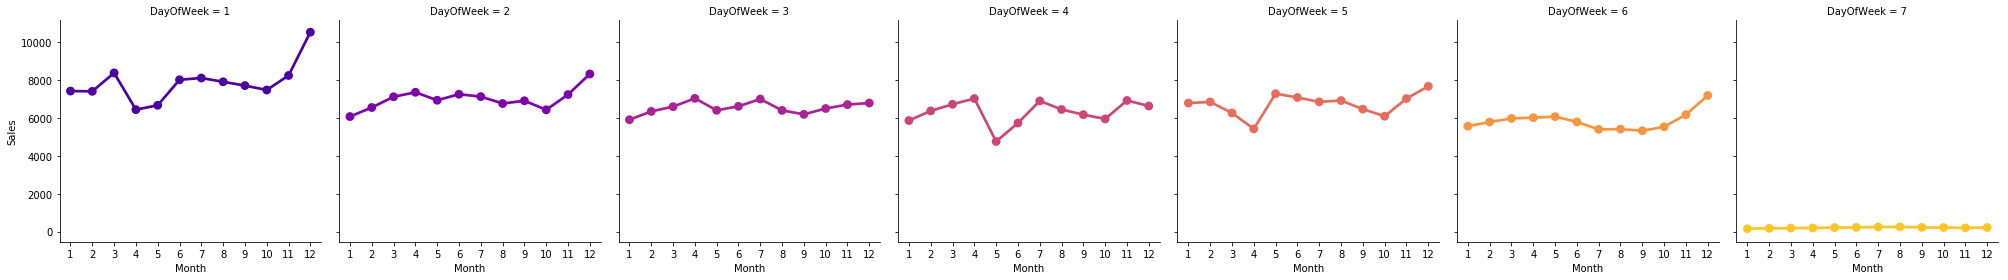

In [50]:
# 销售额均值-按星期几排序
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'DayOfWeek') 

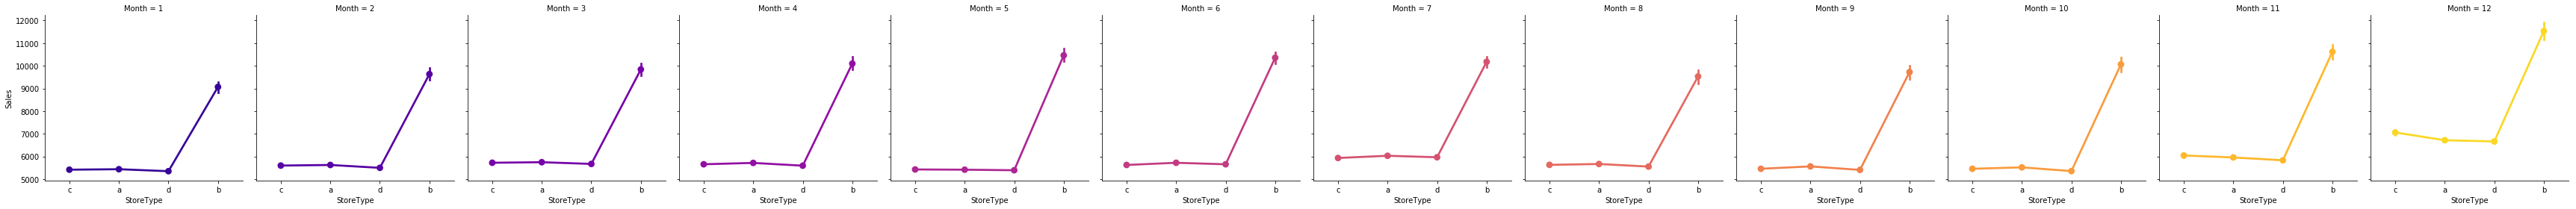

In [51]:
# 销售额-按月份
sns.factorplot(data = train_store, x = 'StoreType', y = "Sales", 
               col = 'Month', 
               palette = 'plasma',
               hue = 'Month') 

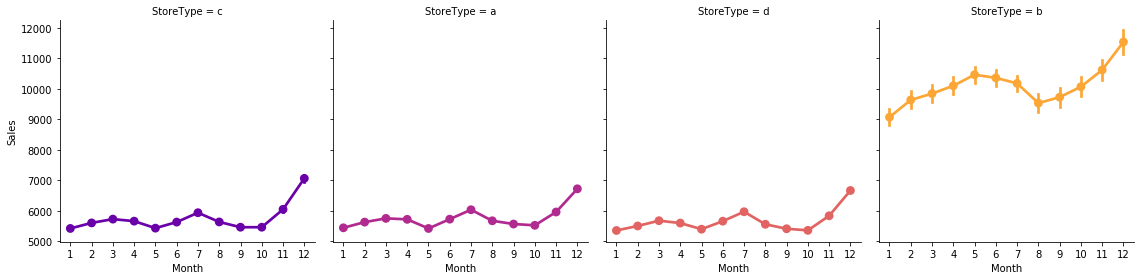

In [52]:
# 销售额-按店类型
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType') 

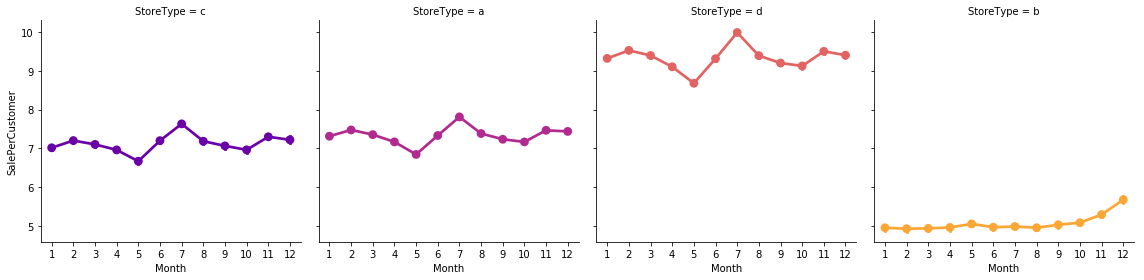

In [53]:
# 单人消费额度-按店类型
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType') 

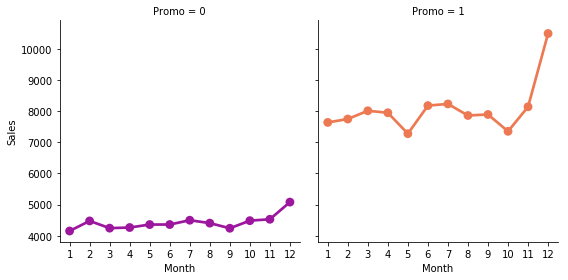

In [54]:
# 销售额均值-对比有无促销(Promo)
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               palette = 'plasma',
               hue = 'Promo',
               ) 

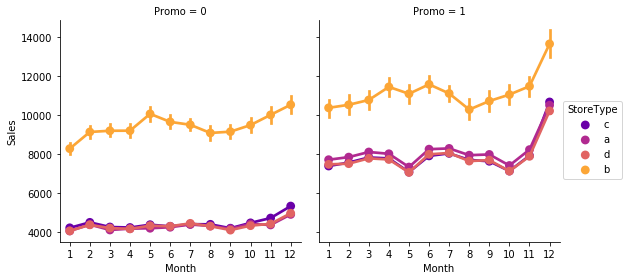

In [55]:
# 销售额均值-对比有无促销(Promo)
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               palette = 'plasma',
               hue = 'StoreType') 

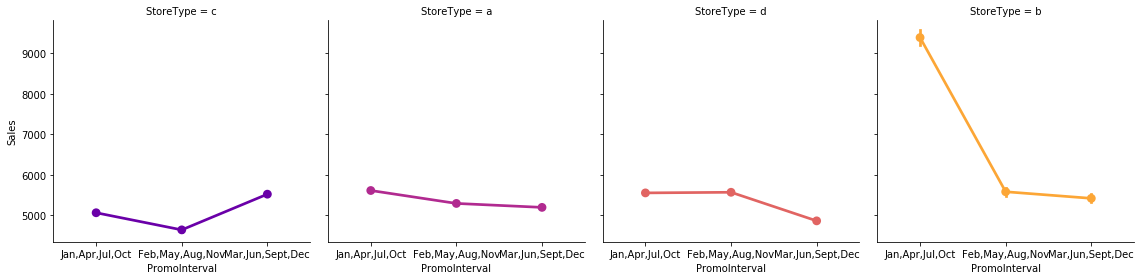

In [56]:
# 各门店销售额均值-按促销时间段
sns.factorplot(data = train_store, x = 'PromoInterval', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType') 

In [57]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,9.482883
1,2,5,6064,625,1,1,0,1,2015,7,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,8314,821,1,1,0,1,2015,7,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,13995,1498,1,1,0,1,2015,7,...,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,9.342457
4,5,5,4822,559,1,1,0,1,2015,7,...,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,8.626118


In [58]:
#对测试集和训练集分别features和object的区分
X_train = train_store.drop(['Sales','Customers','SalePerCustomer'],axis=1)
X_train = pd.merge(X_train, store_etc1, how = 'left', on = 'Store')
X_train = pd.merge(X_train, store_etc2, how = 'left', on = 'DayOfWeek')
X_train = pd.merge(X_train, store_etc3, how = 'left', on = 'Open')
X_train = pd.merge(X_train, store_etc4, how = 'left', on = 'Promo')
X_train = pd.merge(X_train, store_etc5, how = 'left', on = 'SchoolHoliday')
X_train = pd.merge(X_train, store_etc6, how = 'left', on = 'Year')
X_train = pd.merge(X_train, store_etc7, how = 'left', on = 'Month')
X_train = pd.merge(X_train, store_etc8, how = 'left', on = 'Day')
X_train = pd.merge(X_train, store_etc9, how = 'left', on = 'StateHoliday') 
X_train = pd.merge(X_train, store_etc10, how = 'left', on = 'StoreType')
X_train = pd.merge(X_train, store_etc11, how = 'left', on = 'Assortment')
X_train = pd.merge(X_train, store_etc12, how = 'left', on = 'CompetitionOpenSinceMonth')
X_train = pd.merge(X_train, store_etc13, how = 'left', on = 'Promo2')
X_train = pd.merge(X_train, store_etc14, how = 'left', on = 'PromoInterval')
X_train = pd.merge(X_train, store_etc15, how = 'left', on = 'Store')
X_train = pd.merge(X_train, store_etc16, how = 'left', on = 'DayOfWeek')
X_train = pd.merge(X_train, store_etc17, how = 'left', on = 'Open')
X_train = pd.merge(X_train, store_etc18, how = 'left', on = 'Promo')
X_train = pd.merge(X_train, store_etc19, how = 'left', on = 'SchoolHoliday')
X_train = pd.merge(X_train, store_etc20, how = 'left', on = 'Year')
X_train = pd.merge(X_train, store_etc21, how = 'left', on = 'Month')
X_train = pd.merge(X_train, store_etc22, how = 'left', on = 'Day')
X_train = pd.merge(X_train, store_etc23, how = 'left', on = 'StateHoliday') 
X_train = pd.merge(X_train, store_etc24, how = 'left', on = 'StoreType')
X_train = pd.merge(X_train, store_etc25, how = 'left', on = 'Assortment')
X_train = pd.merge(X_train, store_etc26, how = 'left', on = 'Promo2')
X_train = pd.merge(X_train, store_etc27, how = 'left', on = 'PromoInterval')
Y_train = train_store['Sales']

In [59]:
X_train = pd.get_dummies(X_train)

In [60]:
X_train.fillna(0, inplace = True)
X_train.isnull().sum()

Store                              0
DayOfWeek                          0
Open                               0
Promo                              0
SchoolHoliday                      0
Year                               0
Month                              0
Day                                0
CompetitionDistance                0
CompetitionOpenSinceMonth          0
CompetitionOpenSinceYear           0
Promo2                             0
Promo2SinceWeek                    0
Promo2SinceYear                    0
AvgPerStore                        0
AvgPerDayOfWeek                    0
AvgPerOpen                         0
AvgPerPromo                        0
AvgPerSchoolHoliday                0
AvgPerYear                         0
AvgPerMonth                        0
AvgPerDay                          0
AvgPerStateHoliday                 0
AvgPerStoreType                    0
AvgPerAssortment                   0
AvgPerCompetitionOpenSinceMonth    0
AvgPerPromo2                       0
A

In [61]:
X_train = X_train.drop(['StateHoliday_0'],axis=1)

In [62]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [81]:
#该评价指标用来评价模型好坏  
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))


def rmspe_xg(yhat, y):  
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [64]:
def train_predict(model, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - model: 模型
       - sample_size: sample大小
       - X_train: 训练集特征
       - Y_train: 训练集的销售额
       - X_val: 验证集特征
       - Y_val: 验证集的销售额
    '''
    
    results = {}
    
    # TODO：使用sample_size大小的训练数据来拟合模型
    start = time() # 获得程序开始时间
    model = model.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end-start
    
    # TODO: 得到在验证集上的预测值
    start = time() # 获得程序开始时间
    predictions_val = model.predict(X_val)
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end-start
               
    # TODO：计算验证集上的rmspe-score
    results['RMSPE'] = rmspe(Y_val,predictions_val)
       
    # 成功
    print "{} 训练了{} 个samples.".format(model.__class__.__name__, sample_size)
        
    # 返回结果
    return results

In [65]:
features = []
features = list(X_train.columns)

In [66]:
dtrain = xgb.DMatrix(X_train[features], Y_train) 
dval = xgb.DMatrix(X_val[features], Y_val)

In [67]:
print features

['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month', 'Day', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'AvgPerStore', 'AvgPerDayOfWeek', 'AvgPerOpen', 'AvgPerPromo', 'AvgPerSchoolHoliday', 'AvgPerYear', 'AvgPerMonth', 'AvgPerDay', 'AvgPerStateHoliday', 'AvgPerStoreType', 'AvgPerAssortment', 'AvgPerCompetitionOpenSinceMonth', 'AvgPerPromo2', 'AvgPerPromoInterval', 'AvgPerCustomerPerStore', 'AvgPerCustomerPerDayOfWeek', 'AvgPerCustomerPerOpen', 'AvgPerCustomerPerPromo', 'AvgPerCustomerPerSchoolHoliday', 'AvgPerCustomerPerYear', 'AvgPerCustomerPerMonth', 'AvgPerCustomerPerDay', 'AvgPerCustomerPerStateHoliday', 'AvgPerCustomerPerStoreType', 'AvgPerCustomerPerAssortment', 'AvgPerCustomerPerPromo2', 'AvgPerCustomerPerPromoInterval', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment

In [68]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [69]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }

In [70]:
num_boost_round = 1200

In [80]:
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=200,
                feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:6323.84	eval-rmse:6324.41	train-rmspe:nan	eval-rmspe:nan
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.


/home/bairui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/home/bairui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in expm1
  
/home/bairui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bairui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


[1]	train-rmse:5716.69	eval-rmse:5717.84	train-rmspe:nan	eval-rmspe:nan
[2]	train-rmse:5224.53	eval-rmse:5226.09	train-rmspe:nan	eval-rmspe:nan
[3]	train-rmse:4731.62	eval-rmse:4733.81	train-rmspe:nan	eval-rmspe:nan
[4]	train-rmse:4293.04	eval-rmse:4295.47	train-rmspe:nan	eval-rmspe:nan
[5]	train-rmse:3942.25	eval-rmse:3945.12	train-rmspe:nan	eval-rmspe:nan
[6]	train-rmse:3626.54	eval-rmse:3629.21	train-rmspe:nan	eval-rmspe:nan
[7]	train-rmse:3358.49	eval-rmse:3361.26	train-rmspe:nan	eval-rmspe:nan
[8]	train-rmse:3113.44	eval-rmse:3117.2	train-rmspe:nan	eval-rmspe:nan
[9]	train-rmse:2845.01	eval-rmse:2849.73	train-rmspe:nan	eval-rmspe:nan
[10]	train-rmse:2649.49	eval-rmse:2654.26	train-rmspe:nan	eval-rmspe:nan
[11]	train-rmse:2476.89	eval-rmse:2482.15	train-rmspe:nan	eval-rmspe:nan
[12]	train-rmse:2329.64	eval-rmse:2335.5	train-rmspe:nan	eval-rmspe:nan
[13]	train-rmse:2147.23	eval-rmse:2154.1	train-rmspe:nan	eval-rmspe:nan
[14]	train-rmse:2031.33	eval-rmse:2038.72	train-rmspe:nan	eval-

KeyboardInterrupt: 

In [ ]:
# 载入xgboost
model = xgb.XGBRegressor(booster='gbtree',learning_rate=0.001,max_depth=10,tree_method='gpu_hist',random_state=0,n_estimators=100,base_score=0.5)
# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = int(X_train.shape[0] * 1)
# 收集模型的结果
results = {}
for i in [samples_1, samples_10, samples_100]:
    results[i] = train_predict(model, i, X_train, Y_train, X_val, Y_val)
#     打印训练时间格式精确到小数点两位
    print "训练时间花费{:.2f}秒,预测时间花费为{:.2f}秒,RMSPE值为{:.5f}".format(results[i]['train_time'],results[i]['pred_time'],results[i]['RMSPE'])

In [ ]:
xgb.plot_importance(model,max_num_features=15)

In [ ]:
final_model = xgb.XGBRegressor(booster='gbtree',learning_rate=0.003,max_depth=14,tree_method='gpu_hist',random_state=0,n_estimators=500,base_score=0.5,subsample=0.7,max_bin=1115)
# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = int(X_train.shape[0] * 1)
# 收集模型的结果
results = {}
samples_100
results[samples_100] = train_predict(final_model, samples_100, X_train, Y_train, X_val, Y_val)
#     打印训练时间格式精确到小数点两位
print "训练时间花费{:.2f}秒,预测时间花费为{:.2f}秒,RMSPE值为{:.5f}".format(results[samples_100]['train_time'],results[samples_100]['pred_time'],results[samples_100]['RMSPE'])

In [ ]:
final_model
        

In [ ]:
xgb.plot_importance(final_model)

In [ ]:
df_test['Year']=df_test['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)
df_test['Month']=df_test['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
df_test['Day']=df_test['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)

#将Date特征移除
df_test = df_test.drop("Date",axis = 1)


In [ ]:
X_test = pd.merge(df_test, df_store, how = 'left', on = 'Store')

In [ ]:
from collections import Counter
c = Counter(X_test['Open'])
print c

In [ ]:
X_test['Open'].fillna(0, inplace = True)

In [ ]:
# 转化Stateholiday里的0
X_test['Open']=X_test['Open'].astype('int64')

In [ ]:
type(X_test['Open'][1])

In [ ]:
#对测试集和训练集分别features和object的区分
X_test = pd.merge(X_test, store_etc1, how = 'left', on = 'Store')
X_test = pd.merge(X_test, store_etc2, how = 'left', on = 'DayOfWeek')
X_test = pd.merge(X_test, store_etc3, how = 'left', on = 'Open')
X_test = pd.merge(X_test, store_etc4, how = 'left', on = 'Promo')
X_test = pd.merge(X_test, store_etc5, how = 'left', on = 'SchoolHoliday')
X_test = pd.merge(X_test, store_etc6, how = 'left', on = 'Year')
X_test = pd.merge(X_test, store_etc7, how = 'left', on = 'Month')
X_test = pd.merge(X_test, store_etc8, how = 'left', on = 'Day')
X_test = pd.merge(X_test, store_etc9, how = 'left', on = 'StateHoliday') 
X_test = pd.merge(X_test, store_etc10, how = 'left', on = 'StoreType')
X_test = pd.merge(X_test, store_etc11, how = 'left', on = 'Assortment')
X_test = pd.merge(X_test, store_etc12, how = 'left', on = 'CompetitionOpenSinceMonth')
X_test = pd.merge(X_test, store_etc13, how = 'left', on = 'Promo2')
X_test = pd.merge(X_test, store_etc14, how = 'left', on = 'PromoInterval')
X_test = pd.merge(X_test, store_etc15, how = 'left', on = 'Store')
X_test = pd.merge(X_test, store_etc16, how = 'left', on = 'DayOfWeek')
X_test = pd.merge(X_test, store_etc17, how = 'left', on = 'Open')
X_test = pd.merge(X_test, store_etc18, how = 'left', on = 'Promo')
X_test = pd.merge(X_test, store_etc19, how = 'left', on = 'SchoolHoliday')
X_test = pd.merge(X_test, store_etc20, how = 'left', on = 'Year')
X_test = pd.merge(X_test, store_etc21, how = 'left', on = 'Month')
X_test = pd.merge(X_test, store_etc22, how = 'left', on = 'Day')
X_test = pd.merge(X_test, store_etc23, how = 'left', on = 'StateHoliday') 
X_test = pd.merge(X_test, store_etc24, how = 'left', on = 'StoreType')
X_test = pd.merge(X_test, store_etc25, how = 'left', on = 'Assortment')
X_test = pd.merge(X_test, store_etc26, how = 'left', on = 'Promo2')
X_test = pd.merge(X_test, store_etc27, how = 'left', on = 'PromoInterval')

In [ ]:
X_test.columns

In [ ]:
#将所有数据进行one-hot编码
X_test = pd.get_dummies(X_test)

In [ ]:
X_test['StateHoliday_b']=0
X_test['StateHoliday_c']=0

In [ ]:
cols = list(X_train.columns)

In [ ]:
cols

In [ ]:
X_test = X_test[cols]

In [ ]:
X_test['CompetitionDistance'].fillna(train_store['CompetitionDistance'].median(), inplace = True)

In [ ]:
predict_test = final_model.predict(X_test)

In [ ]:
submission = pd.read_csv("sample_submission.csv")

In [ ]:
submission['Sales']=predict_test

In [ ]:
submission.to_csv(path_or_buf ="sample_submission.csv",columns=['Id','Sales'])

In [ ]:
submission.shape